In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
import random
import json

## cache

In [2]:
wpr_cache = {}

## helper functions

In [3]:
def get_wpr_soup(state):
    # zip codes are state-separated: https://worldpopulationreview.com/zips/<state>
    if state not in wpr_cache:
        time.sleep(1 + random.random())
        r = requests.get("https://worldpopulationreview.com/zips/" + state)
        soup = BeautifulSoup(r.text, 'html.parser')
        wpr_cache[state] = soup
    return wpr_cache[state]

In [4]:
def get_ht_wd(extent):
    ht = extent[0][1] - extent[0][0]
    wd = extent[1][1] - extent[1][0]
    return ht, wd

In [5]:
def get_extent(state_boundaries, state, border=0):
    points = state_boundaries[state]
    min_lat = min([np.min(x[0]) for x in points]) 
    max_lat = max([np.max(x[0]) for x in points]) 
    min_long = min([np.min(x[1]) for x in points]) 
    max_long = max([np.max(x[1]) for x in points]) 
    return ((min_lat-border, max_lat+border), (min_long-border, max_long+border))

In [6]:
def get_state_boundaries():
    # from https://web.archive.org/web/20130615162524/http://eric.clst.org/wupl/Stuff/gz_2010_us_040_00_500k.json
    with open('data/state_boundaries.json') as f:
        boundaries = json.load(f)
    f.close()

    boundary_by_state = {}
    for feature in boundaries['features']:
        state = feature['properties']['NAME'].lower()
        points = feature['geometry']['coordinates']
        if feature['geometry']['type'] == 'Polygon':
            points = [points,]
        points = [np.array(p[0]).T for p in points]
        points = [(longs % 360 - 360, lats) for longs, lats in points]
        if state == 'hawaii':
            points = [(longs[longs > -171], lats[longs > -171]) for longs, lats in points if sum(longs > -171)]
        boundary_by_state[state] = points
    return boundary_by_state

def plot_state(boundary_by_state, state):
    for lats, longs in boundary_by_state[state]:
         plt.plot(lats, longs, color='black', label=None)

In [7]:
def get_state_names():
    with open('data/states.txt') as f:
        states = f.readlines()
    f.close()
    states = [[i.split(' - ')[0].lower(), i.split(' - ')[1].split('\n')[0]] for i in states]
    return states

In [8]:
def get_pop_by_zip(soup):
    # total number expected
    print(str(soup.find_all('p')[0]), '(pop_by_zip)')
    num_zips = [int(i) for i in str(soup.find_all('p')[0]).split(' ') if i.isnumeric()][0]

    # get table data
    data = []
    rows = soup.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    data = data[1:-5]
    print(len(data), 'found (pop_by_zip)')
    assert len(data) == num_zips

    # now get pandas df for zip + pop
    pop_by_zip = pd.DataFrame(data)
    pop_by_zip.rename(columns = {0: 'Zip', 3: 'pop'}, inplace = True)
    pop_by_zip['Zip'] = pop_by_zip['Zip'].astype(int)
    pop_by_zip['pop'] = pop_by_zip['pop'].str.replace(',', '')
    pop_by_zip['pop'] = pop_by_zip['pop'].astype(float)
    pop_by_zip = pop_by_zip.set_index('Zip')
    return pop_by_zip

In [9]:
def get_zip_by_latlong(state_abbrev):
    # https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/
    zip_by_latlong = pd.read_csv("data/us_zip_by_latlong.csv", delimiter=';')
    zip_by_latlong = zip_by_latlong.set_index('Zip')
    mask = zip_by_latlong['State'] == state_abbrev
    zip_by_latlong = zip_by_latlong[mask]
    print(len(zip_by_latlong), 'found (zip_by_latlong)')
    return zip_by_latlong

In [10]:
def get_null_values(j):
    return j[j['Latitude'].isnull() | j['Longitude'].isnull() | j['pop'].isnull()]

def drop_null_values(j, print_nulls = False):
    null_data = get_null_values(j)
    print(len(null_data), 'null values')
    if print_nulls:
        print(null_data[['pop', 'City', 'Latitude', 'Longitude']])
    to_drop = null_data.index
    for i in to_drop:
        j = j.drop(index=i)
    assert 0 == len(get_null_values(j))
    return j

In [11]:
def plot(j, figsize, ratio, attrs):
    """
    For convenience, I pretend the map is "flat" by latitude and longitude. 
    The projection has a bit of distortion: 
    farther north, it's actually thinner than the image looks.
    """
    # tutorial from http://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
    j.plot(kind="scatter", x="Longitude", y="Latitude",
           s=j['pop']/ratio, label="population",
           alpha=0.35,figsize=figsize, **attrs
    )

In [12]:
def find_com(joined_data):
    """
    I average the latitudes and longitudes to get the population "center of mass".
    Other projections would put the population "center of mass" somewhere slightly different.
    """
    total_pop = sum(joined_data['pop'])
    lat_avg = sum(joined_data['Latitude']*joined_data['pop']) / total_pop
    long_avg = sum(joined_data['Longitude']*joined_data['pop']) / total_pop
    print("Total population:", total_pop)
    print("Population center of mass:", lat_avg, long_avg)
    
    nearby_zip = ((joined_data['Longitude'] - long_avg)**2 + (joined_data['Latitude'] - lat_avg)**2).sort_values().keys()[0]
    nearby_row = joined_data.loc[nearby_zip]
    print('close to', nearby_row[1], ',', nearby_row[2], nearby_row['Latitude'], nearby_row['Longitude'], 'pop', nearby_row['pop'])
    return (lat_avg, long_avg)

In [13]:
def get_geo_data():
    # https://en.wikipedia.org/wiki/List_of_geographic_centers_of_the_United_States
    with open('data/us_geo_centers.txt') as f:
        centers = f.readlines()
    f.close()

    geo_data = {}
    for c in centers:
        c = c.strip().split('\t')
        state = c[0].strip().split(' (')[0].lower()
        lat = c[2].split('°')[0]
        long = c[2].split('°')[1].split(' ')[1]
        geo_data[state] = [float(lat), 0-float(long)]
    return geo_data

# Ok, do it!

In [14]:
print(plt.style.available)

['seaborn-deep', 'seaborn-poster', 'seaborn-white', 'grayscale', 'fast', 'seaborn-whitegrid', 'tableau-colorblind10', 'seaborn-colorblind', 'seaborn', 'classic', 'seaborn-darkgrid', 'seaborn-talk', 'seaborn-muted', 'ggplot', 'seaborn-ticks', 'Solarize_Light2', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark-palette', 'fivethirtyeight', 'dark_background', '_classic_test', 'seaborn-pastel', 'seaborn-dark', 'bmh', 'seaborn-notebook']


<p>Alabama has a total of 641 active zip codes.</p> (pop_by_zip)
641 found (pop_by_zip)
863 found (zip_by_latlong)
5 null values
Total population: 4854769.0
Population center of mass: 33.0098630557977 -86.75305856341686
close to Jemison , Chilton County 32.96512 -86.74405 pop 9116.0
<p>Alaska has a total of 238 active zip codes.</p> (pop_by_zip)
238 found (pop_by_zip)
271 found (zip_by_latlong)
3 null values
Total population: 737979.0
Population center of mass: 61.37638479076777 -149.06966206740154
close to Palmer , Matanuska Susitna County 61.598203000000005 -149.04109 pop 30450.0
<p>Arizona has a total of 367 active zip codes.</p> (pop_by_zip)
367 found (pop_by_zip)
538 found (zip_by_latlong)
10 null values
Total population: 6078929.0
Population center of mass: 33.39770464567069 -111.89137635023026
close to Mesa , Maricopa County 33.381097 -111.8756 pop 39245.0
<p>Arkansas has a total of 590 active zip codes.</p> (pop_by_zip)
590 found (pop_by_zip)
737 found (zip_by_latlong)
4 null v

/home/kunal/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<p>Michigan has a total of 979 active zip codes.</p> (pop_by_zip)
979 found (pop_by_zip)
1203 found (zip_by_latlong)
11 null values
Total population: 9804607.0
Population center of mass: 42.87281722519375 -84.21706990267975
close to Morrice , Shiawassee County 42.845703 -84.16581 pop 2817.0
<p>Minnesota has a total of 884 active zip codes.</p> (pop_by_zip)
884 found (pop_by_zip)
1054 found (zip_by_latlong)
9 null values
Total population: 5506437.0
Population center of mass: 45.19867439208574 -93.57011330008304
close to Rogers , Hennepin County 45.197646 -93.57104 pop 15078.0
<p>Mississippi has a total of 423 active zip codes.</p> (pop_by_zip)
423 found (pop_by_zip)
551 found (zip_by_latlong)
6 null values
Total population: 2979620.0
Population center of mass: 32.57703647345835 -89.57706753027065
close to Lena , Leake County 32.595178999999995 -89.6311 pop 3988.0
<p>Missouri has a total of 1023 active zip codes.</p> (pop_by_zip)
1023 found (pop_by_zip)
1213 found (zip_by_latlong)
8 null

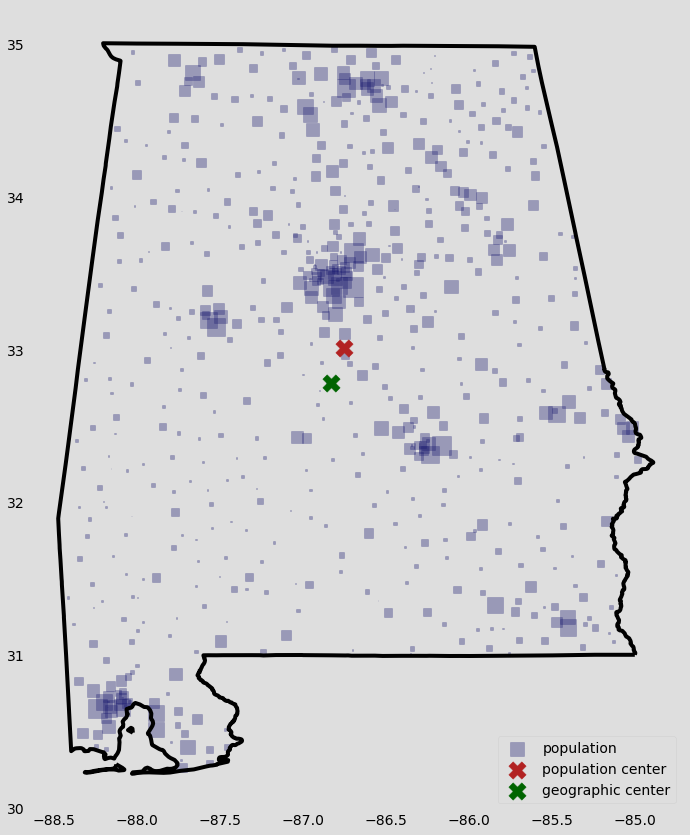

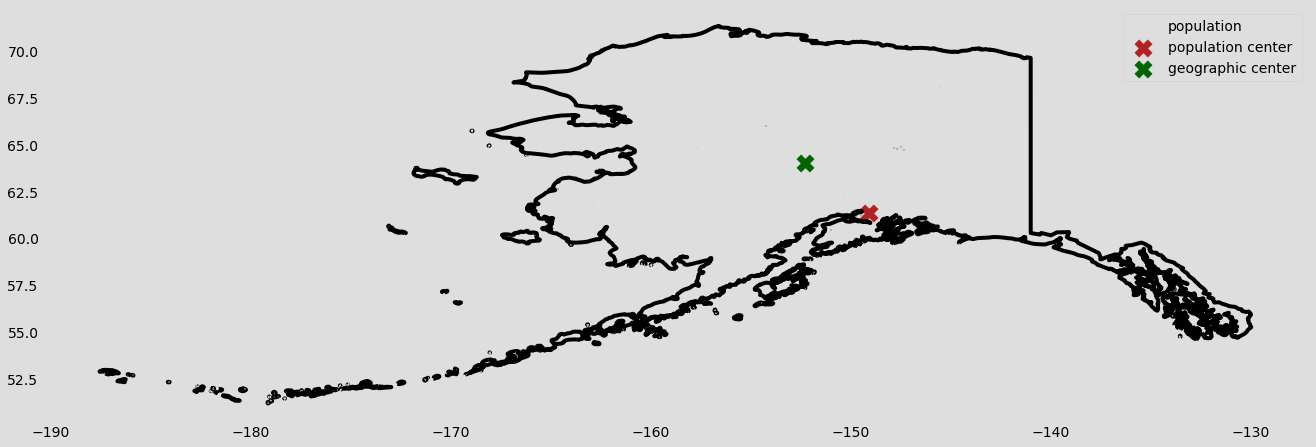

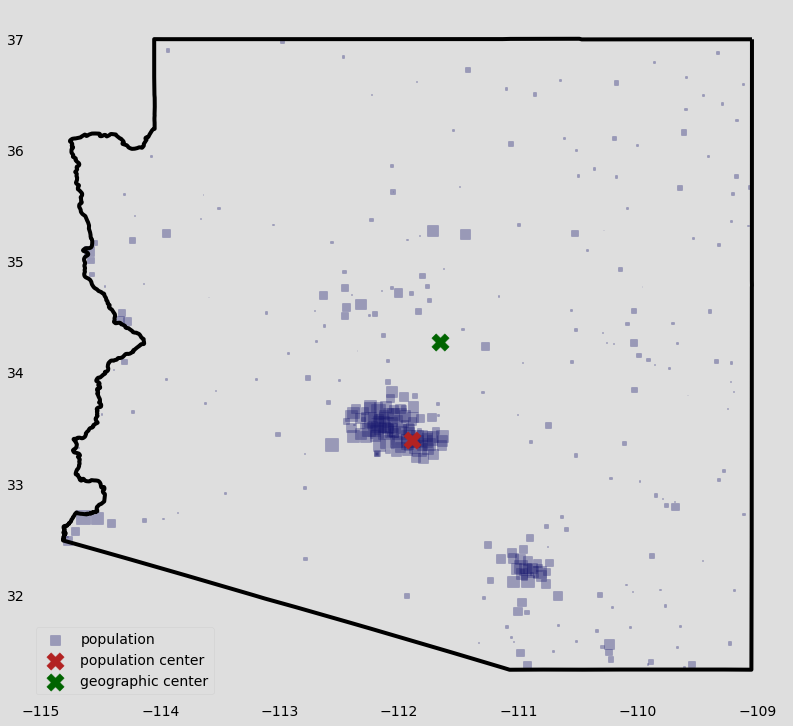

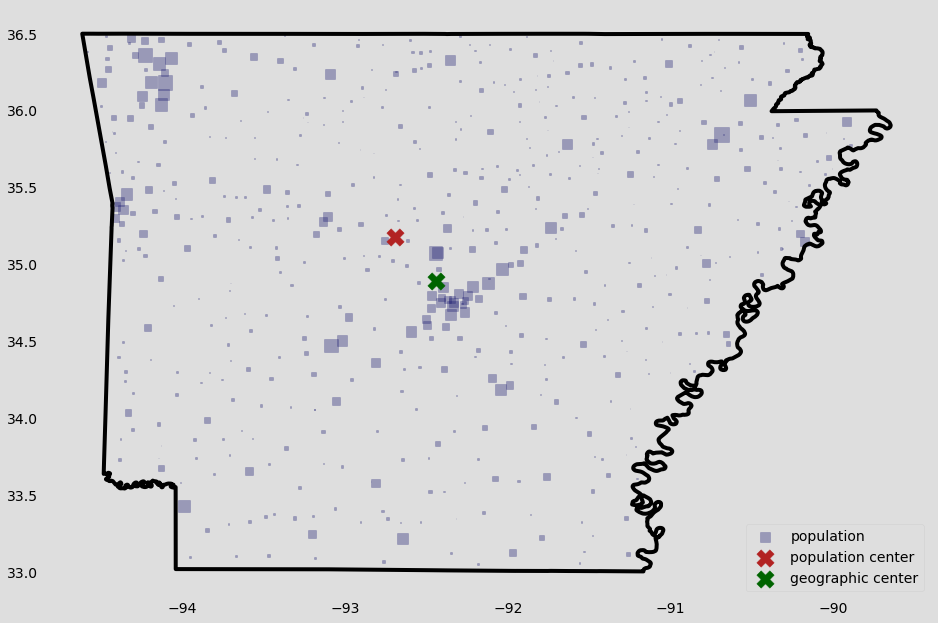

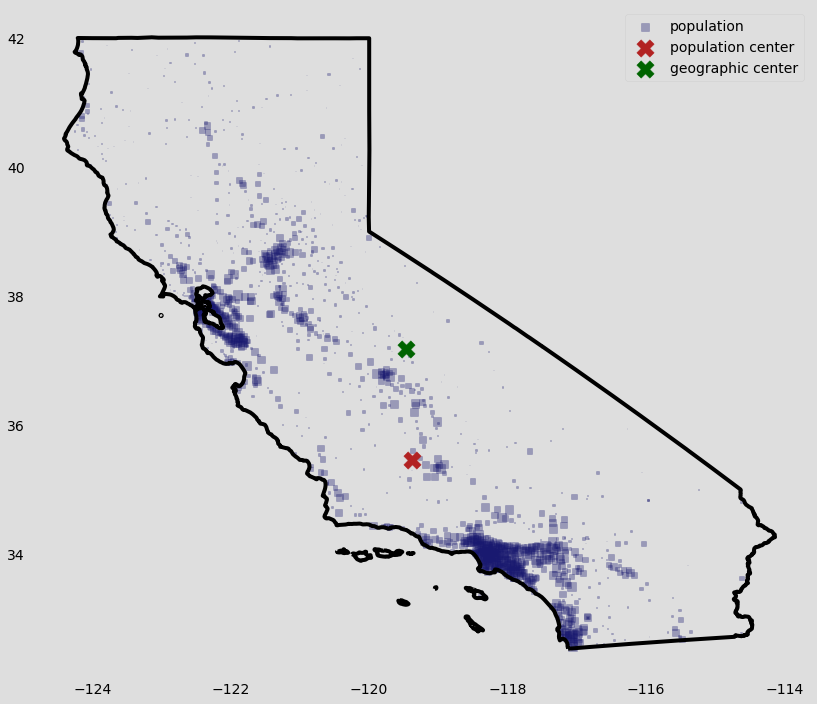

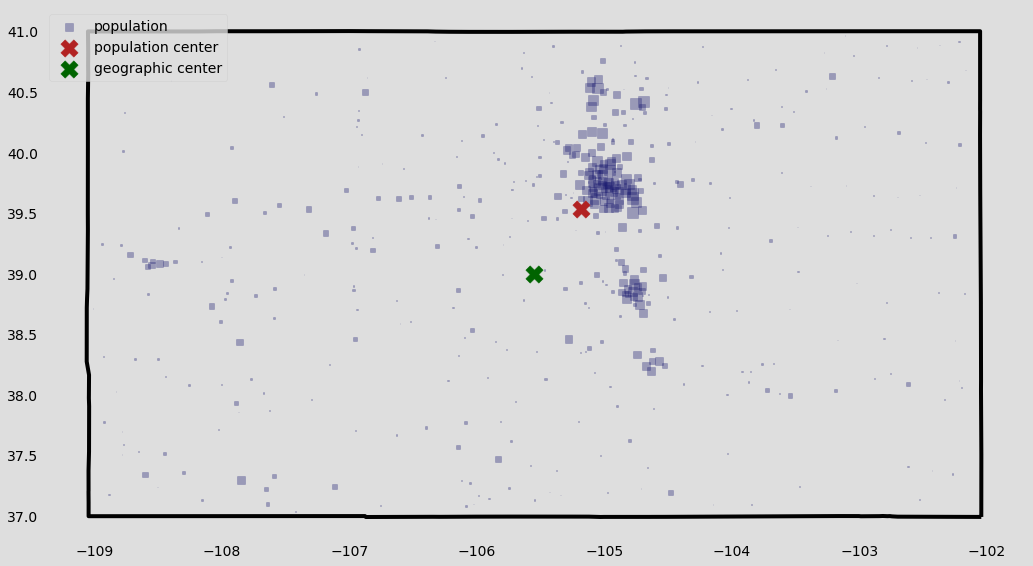

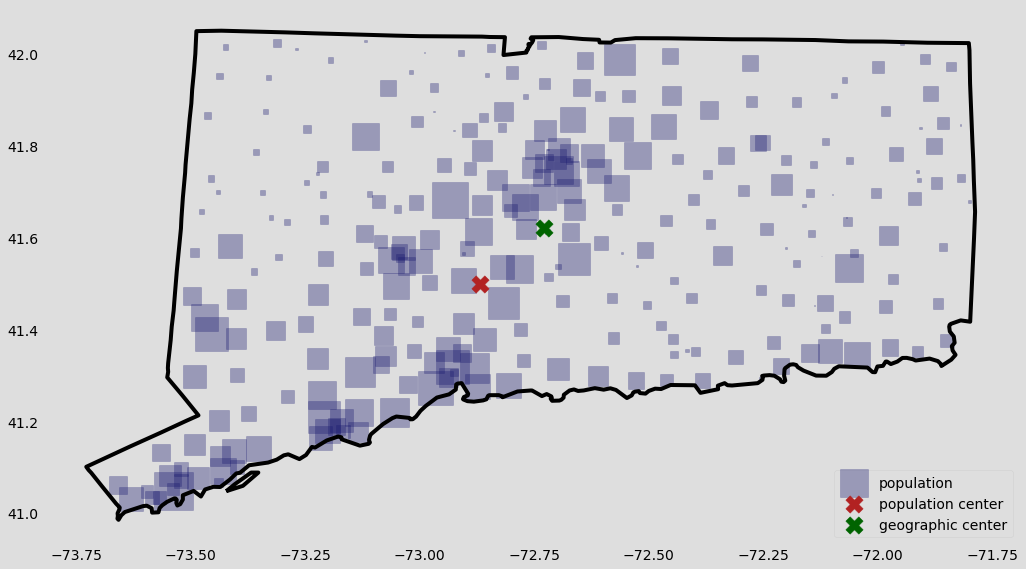

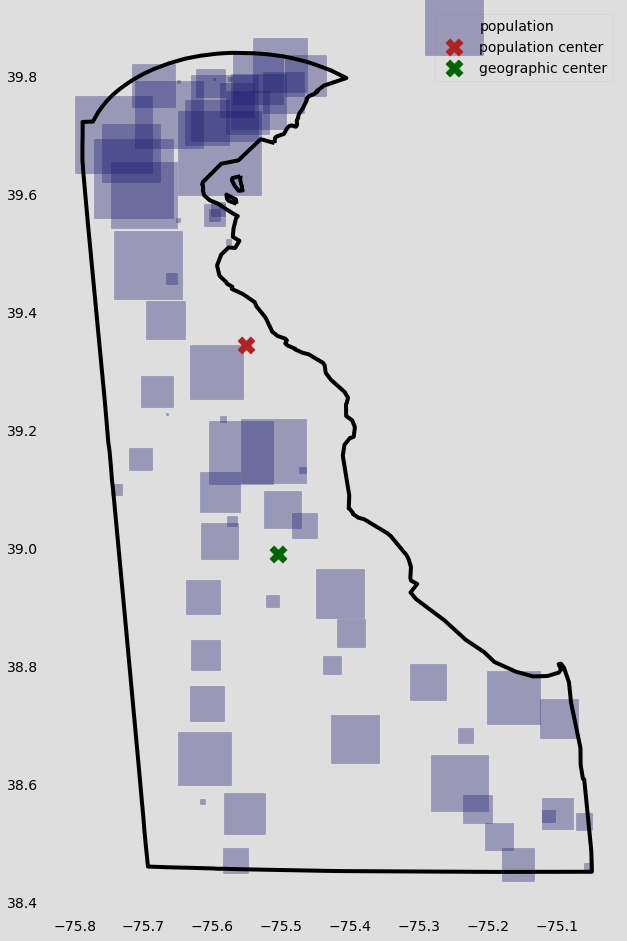

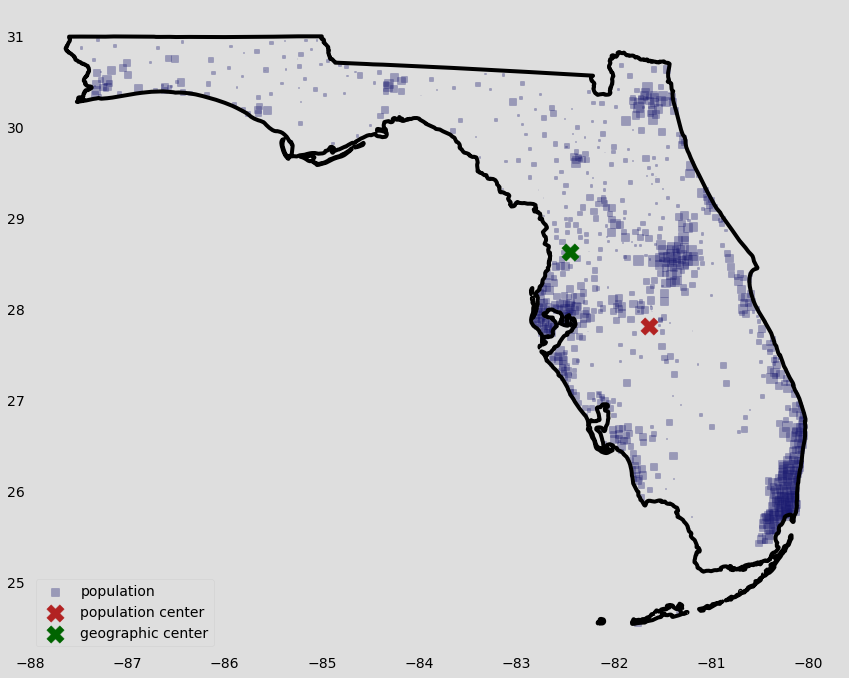

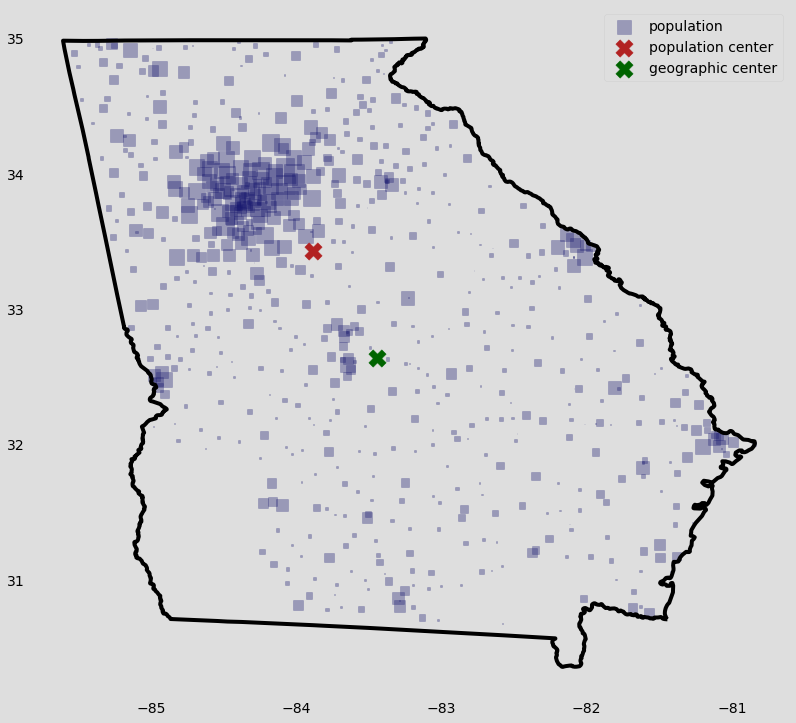

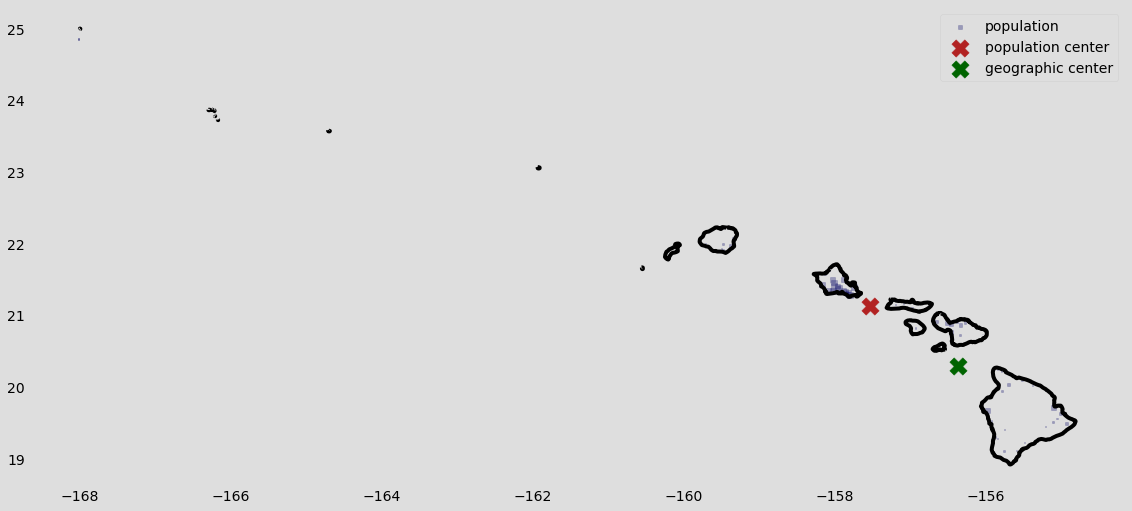

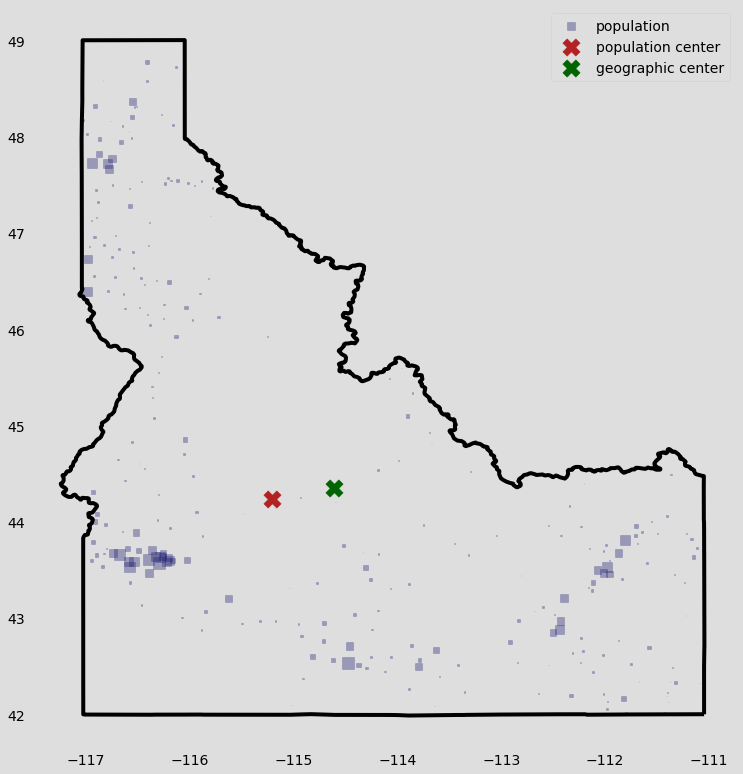

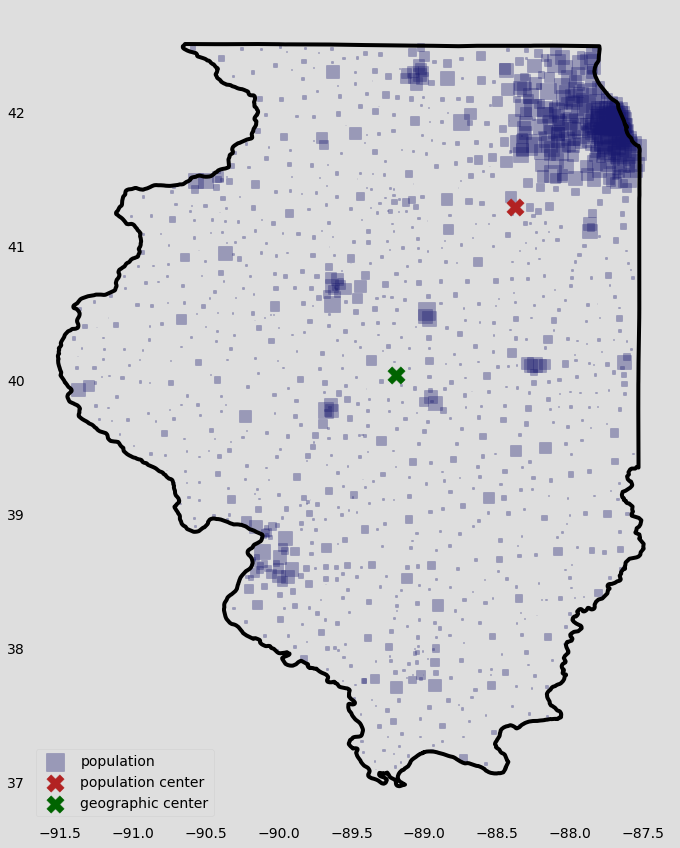

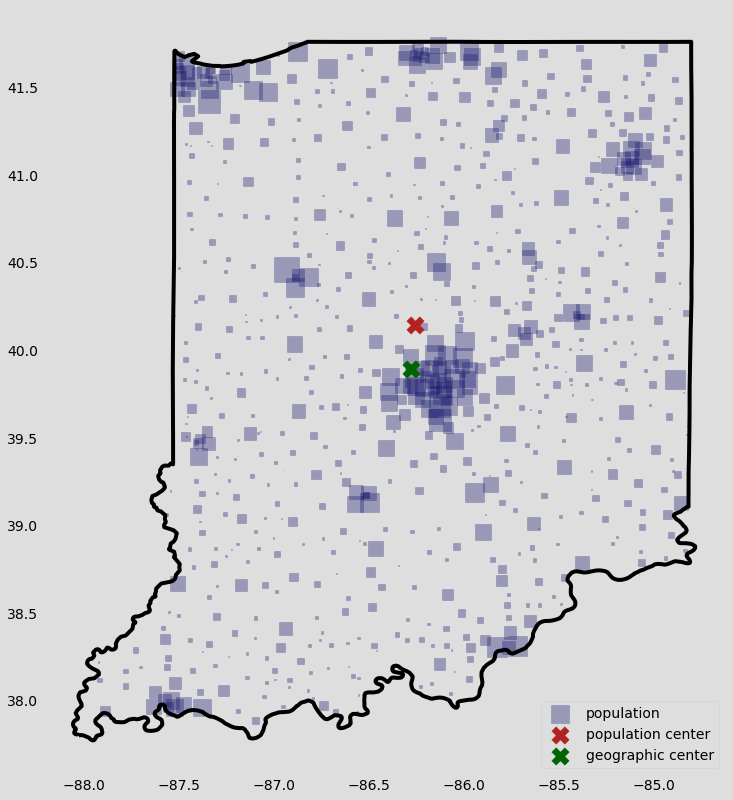

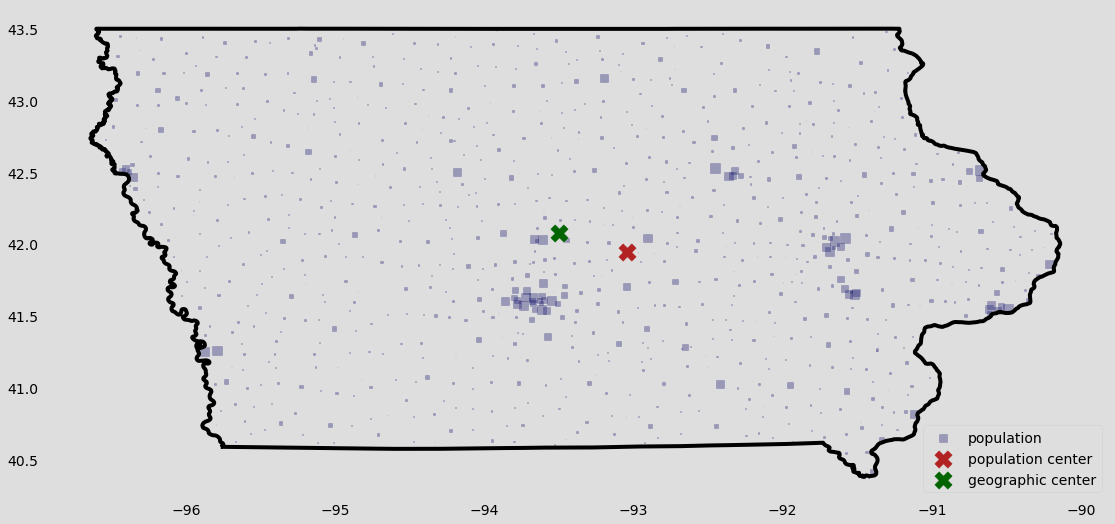

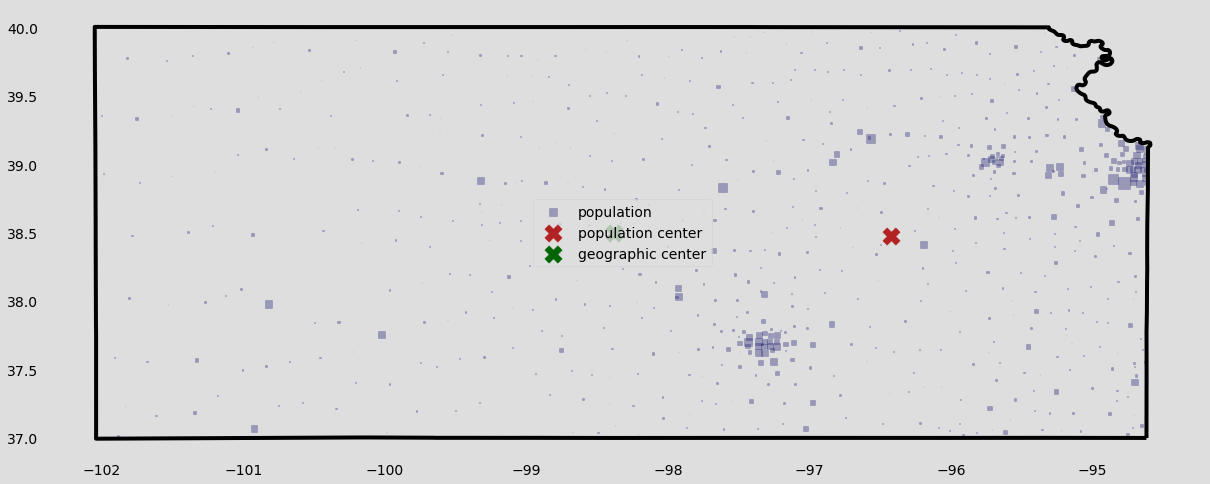

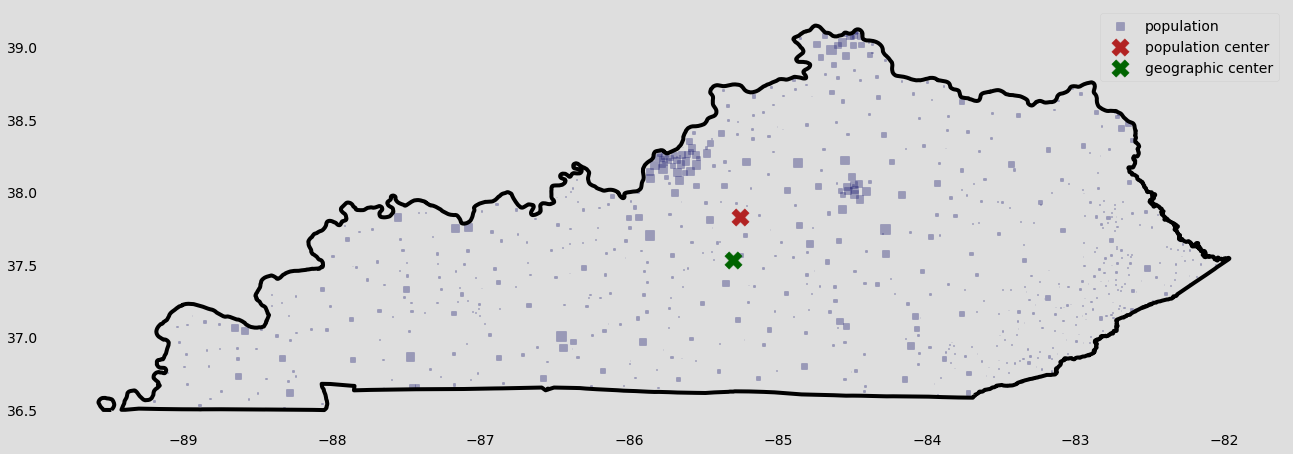

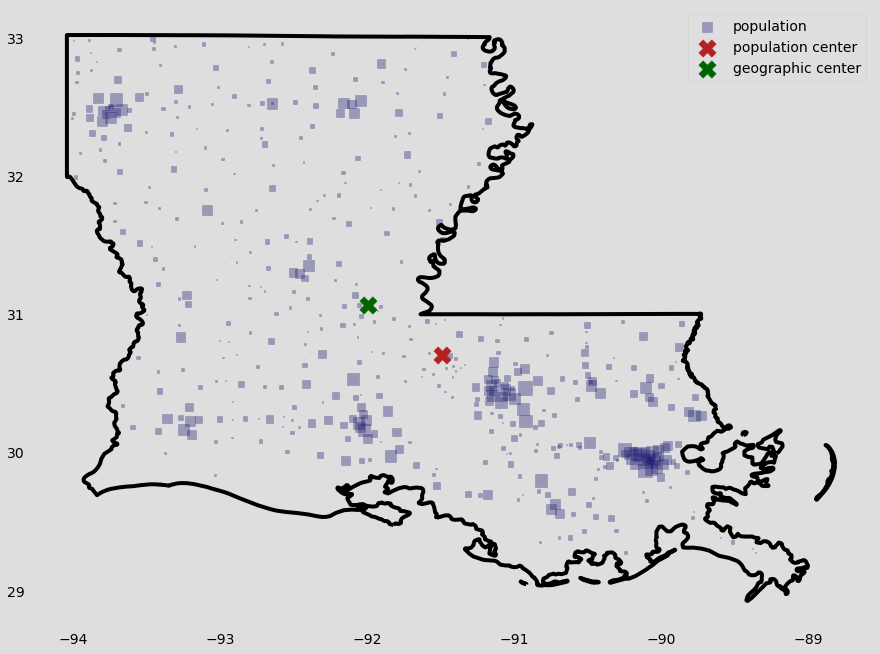

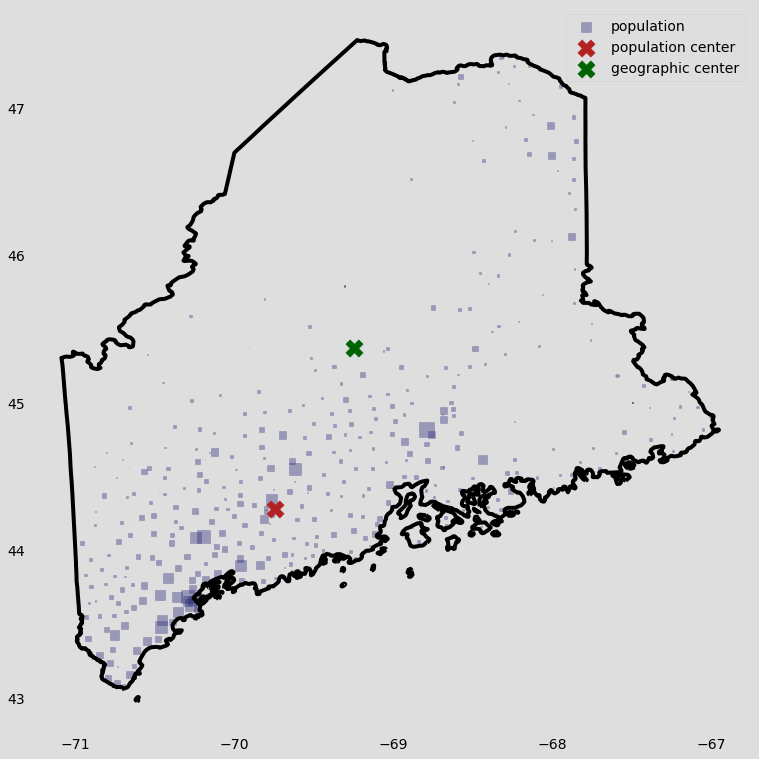

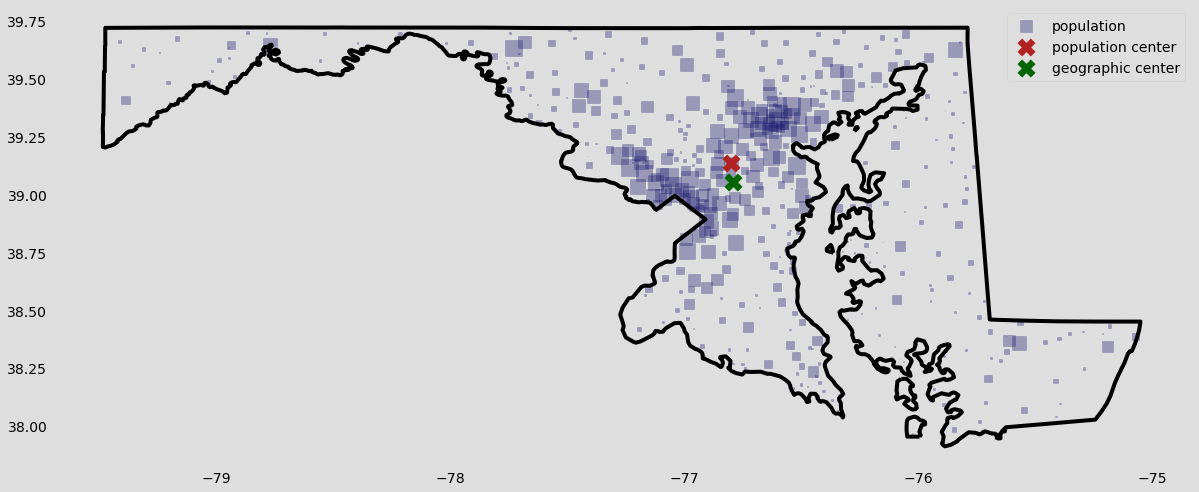

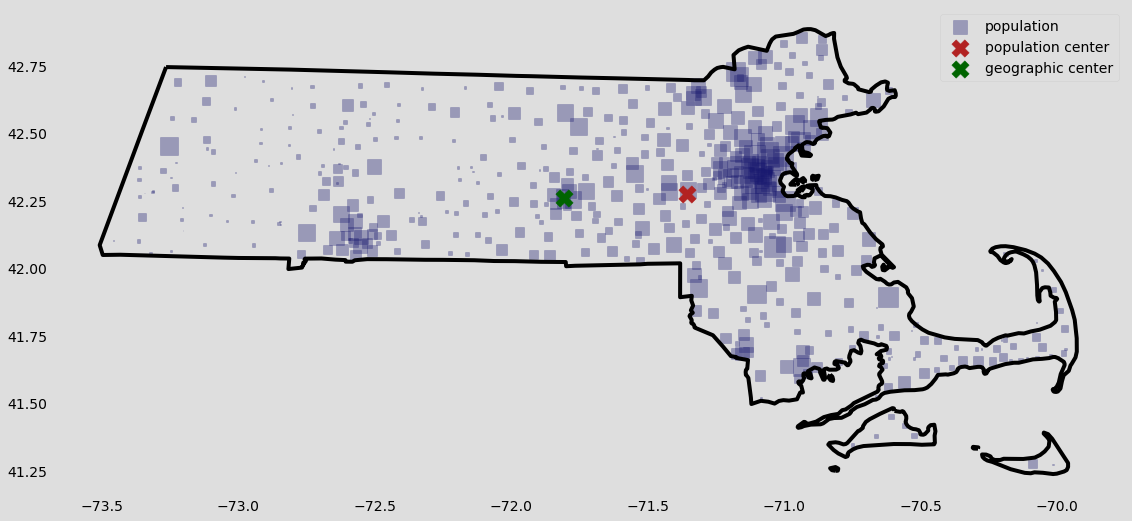

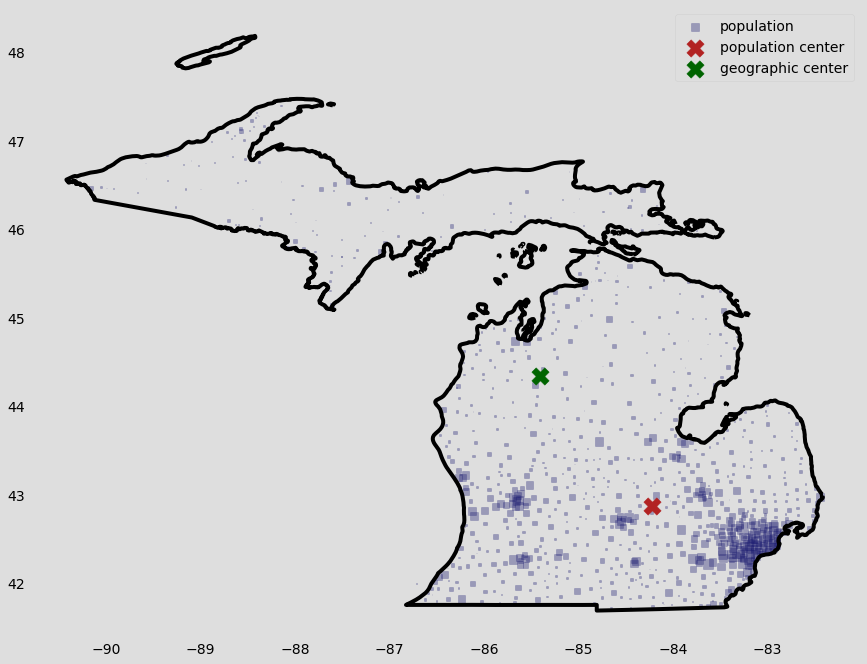

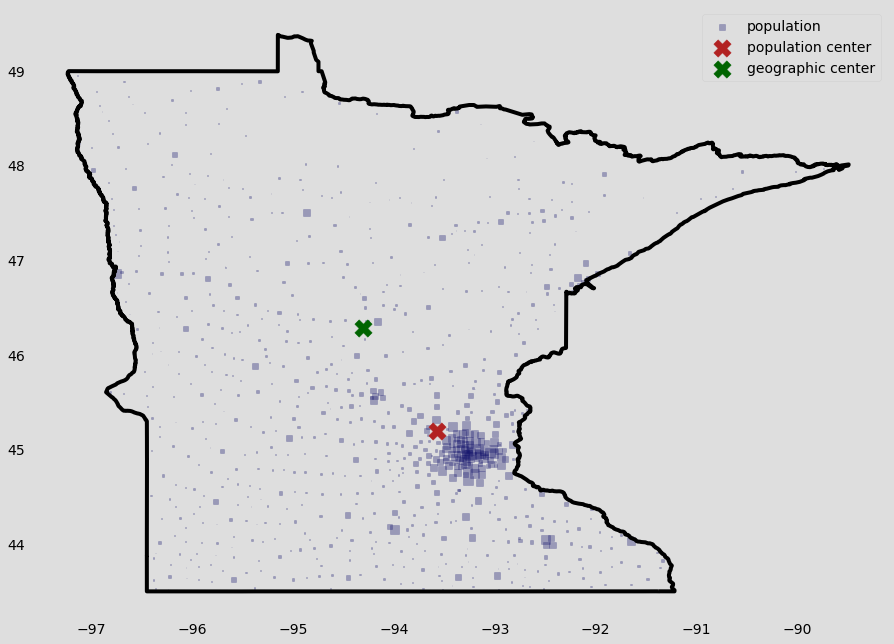

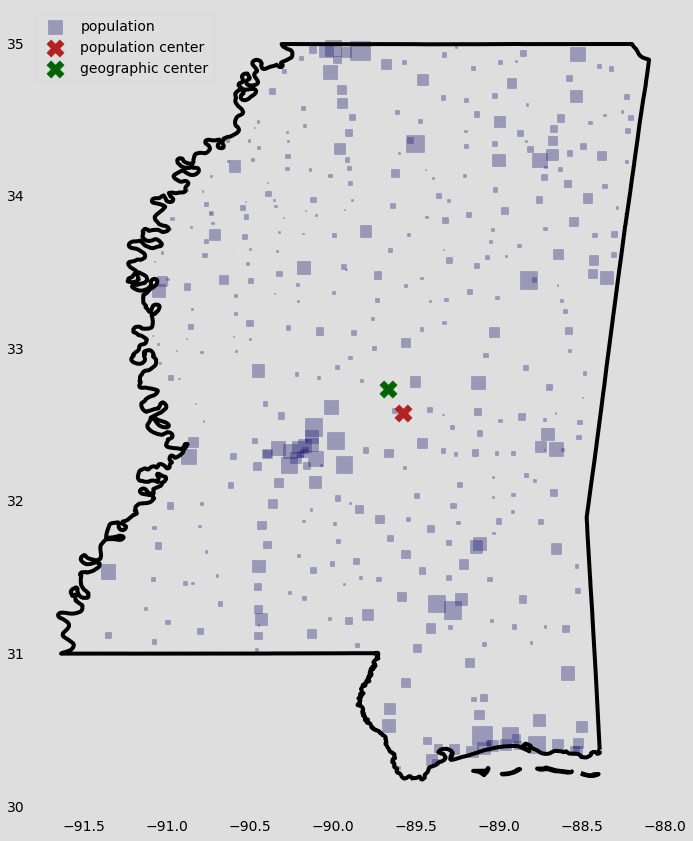

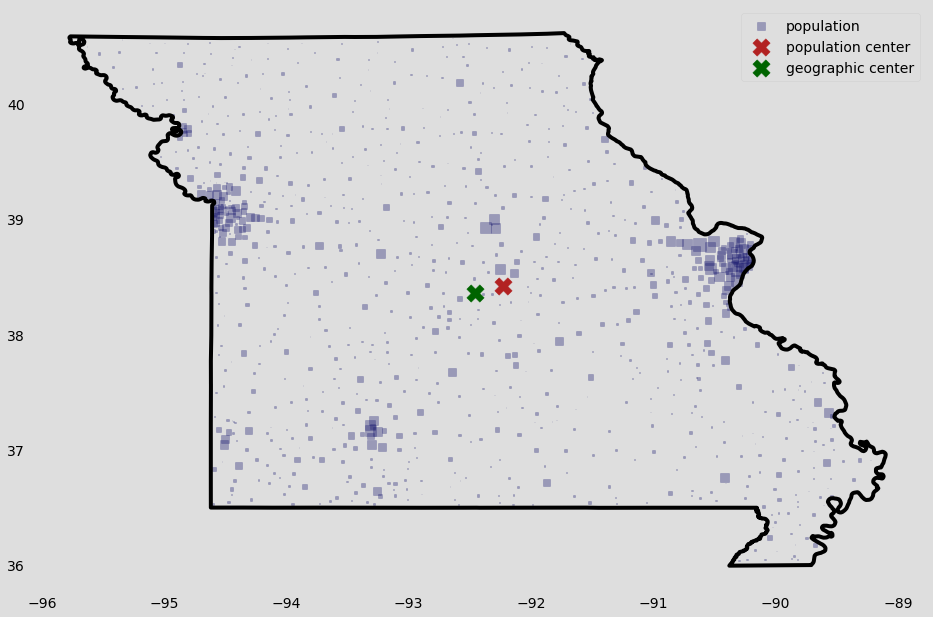

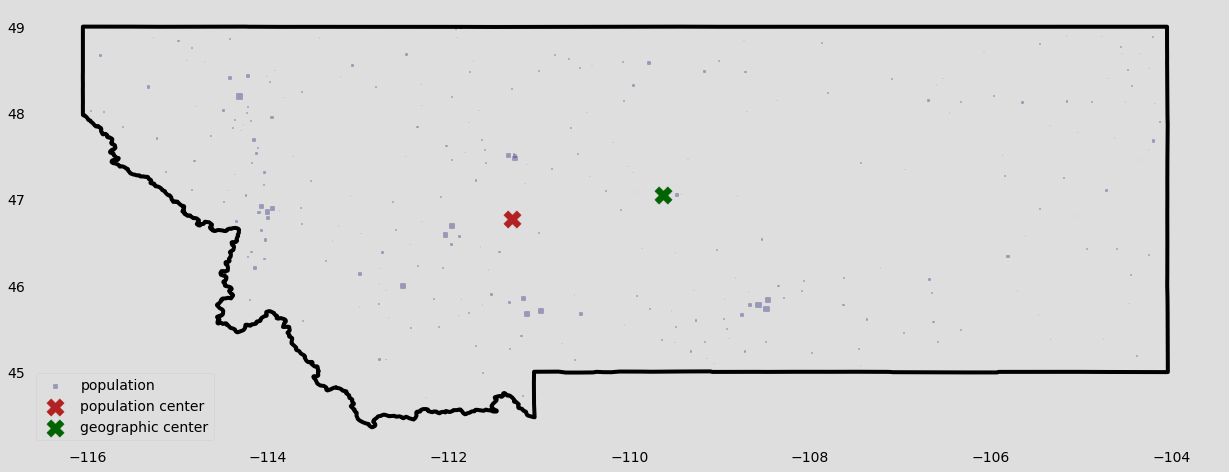

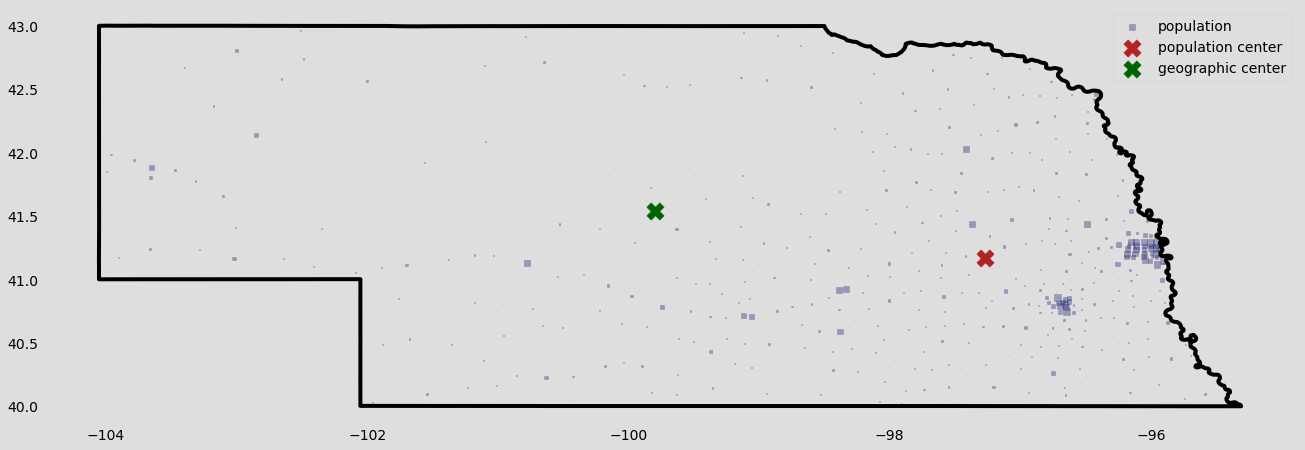

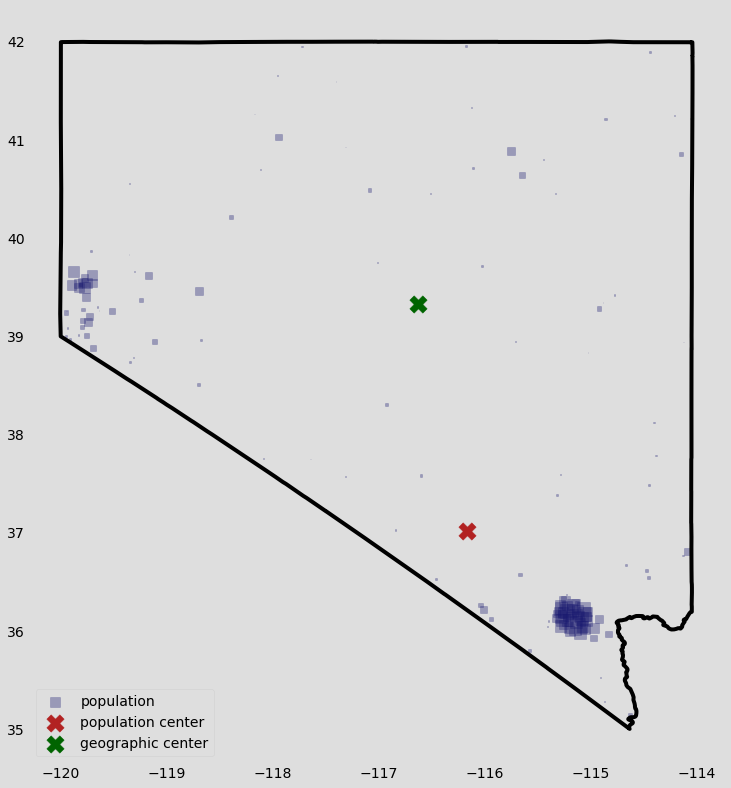

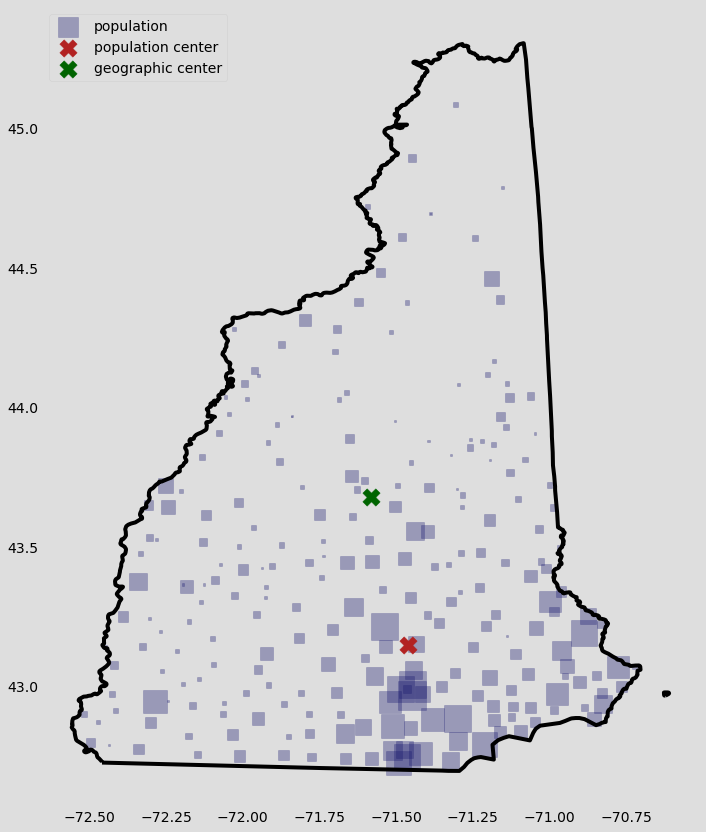

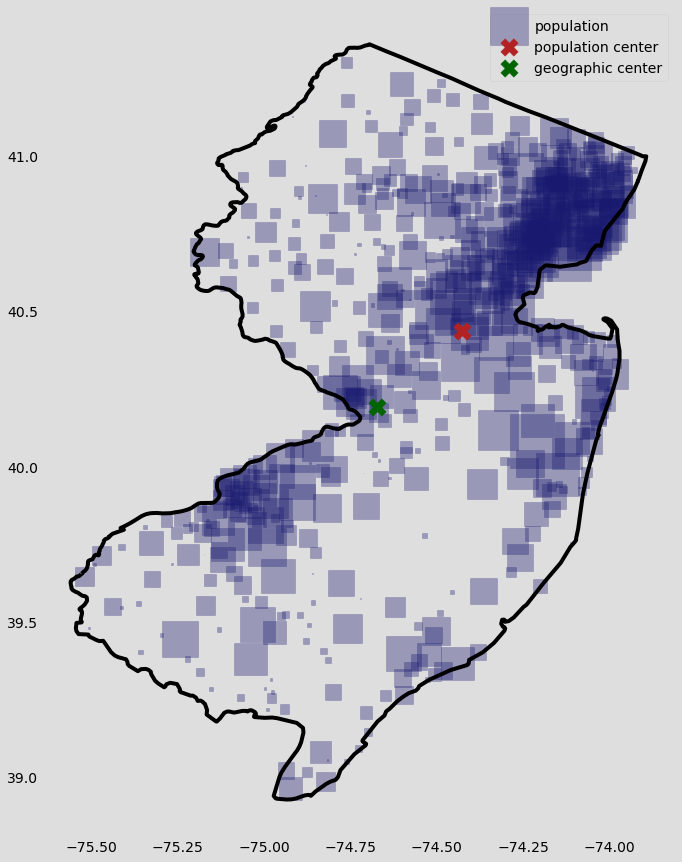

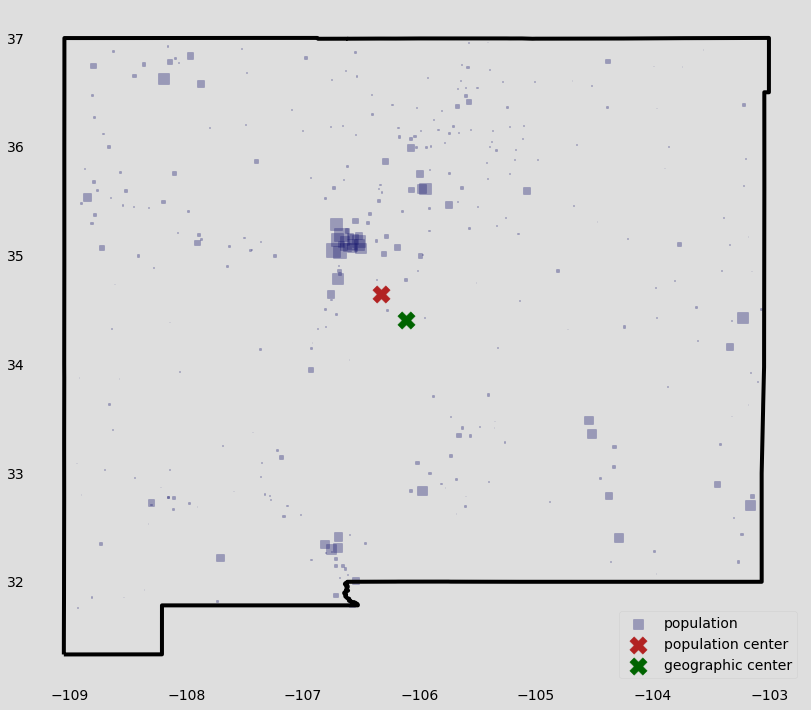

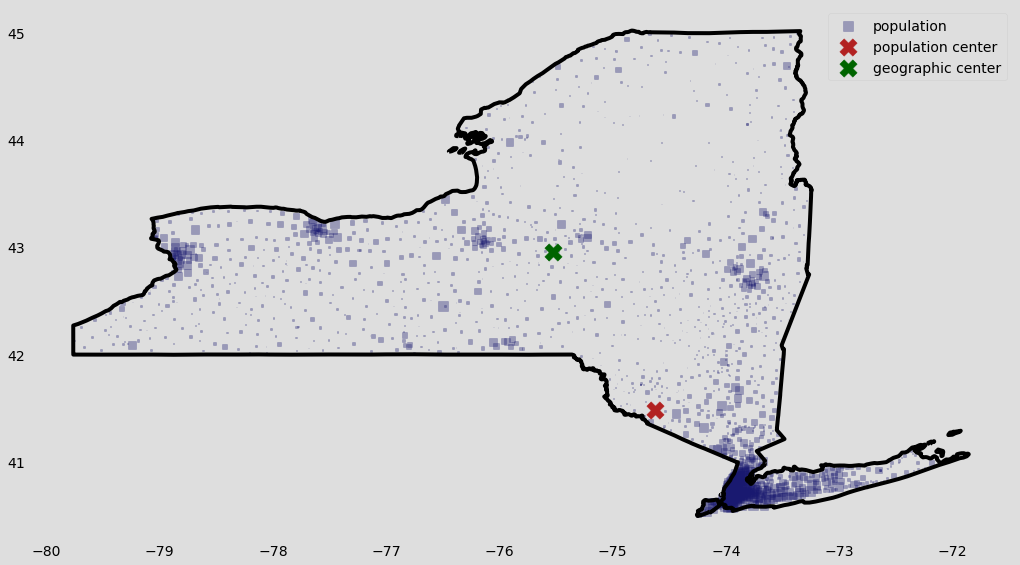

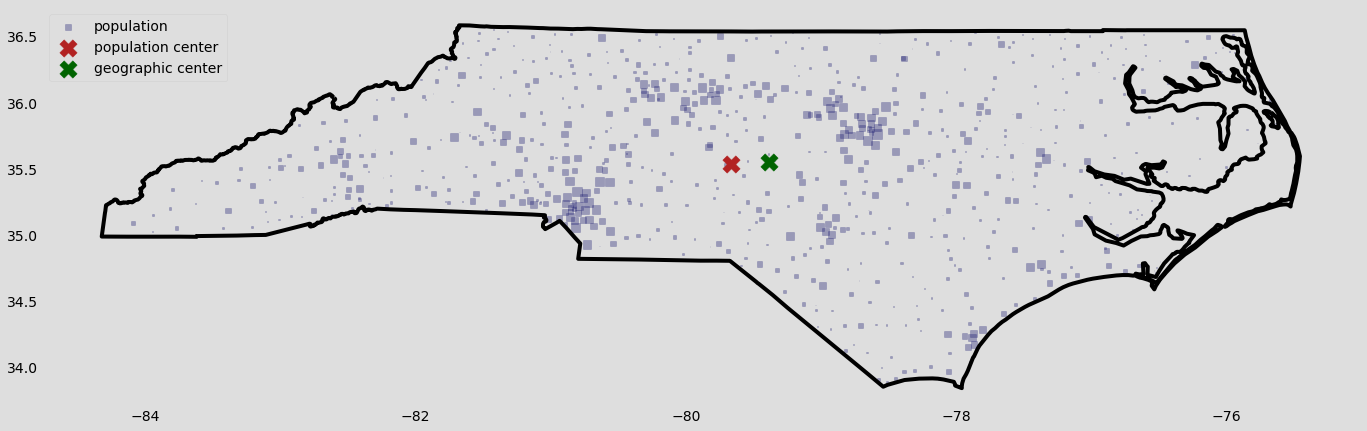

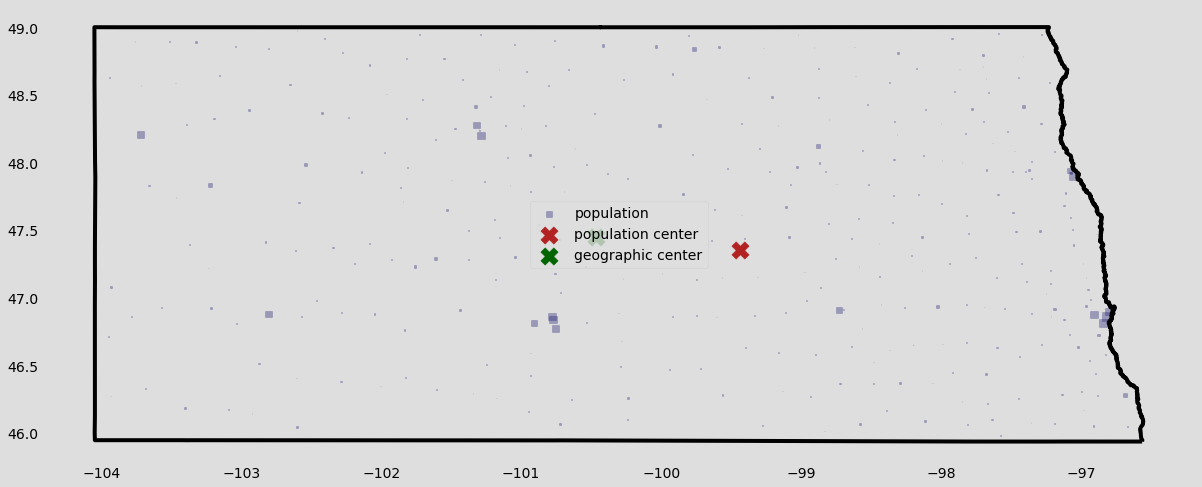

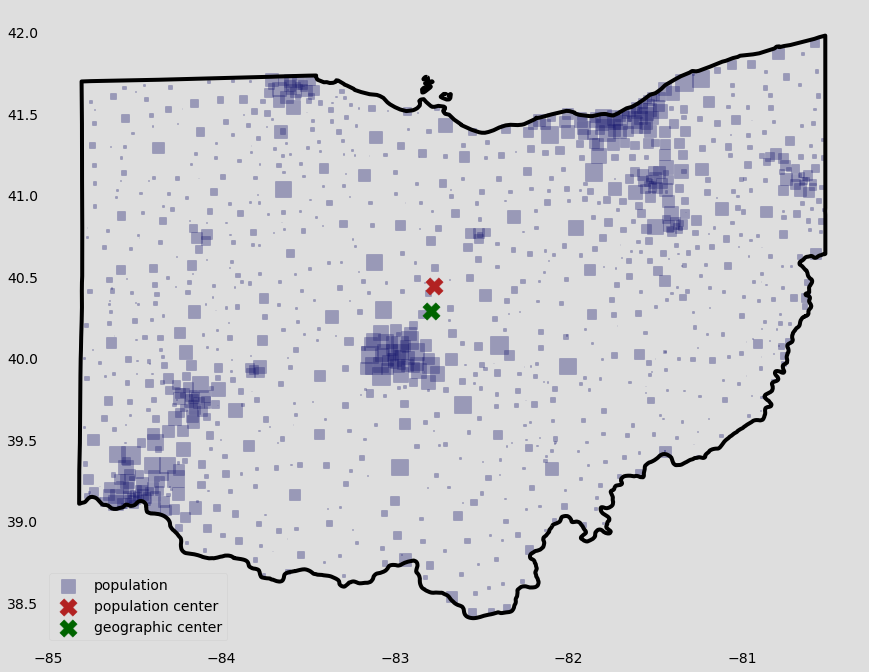

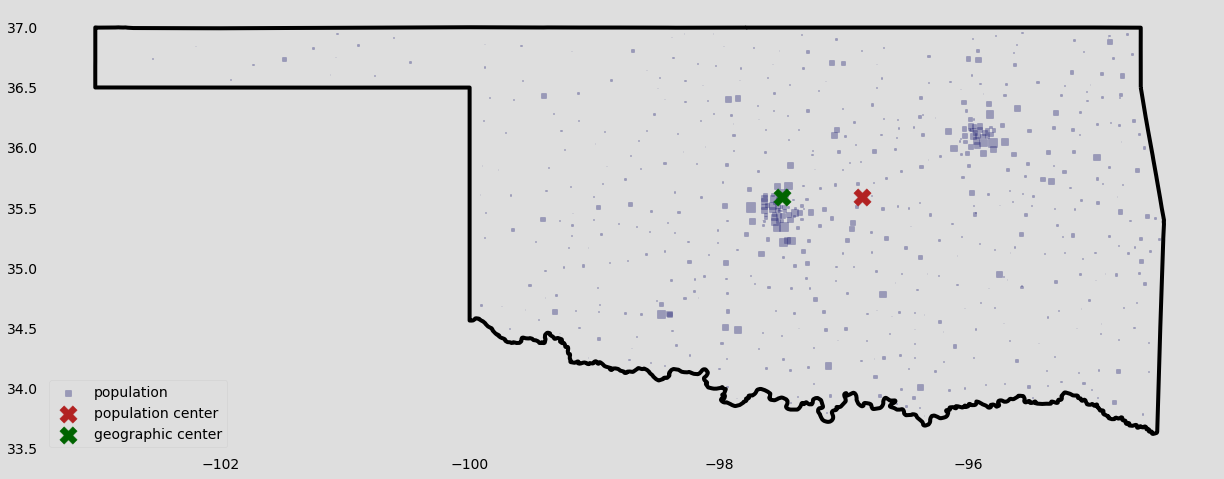

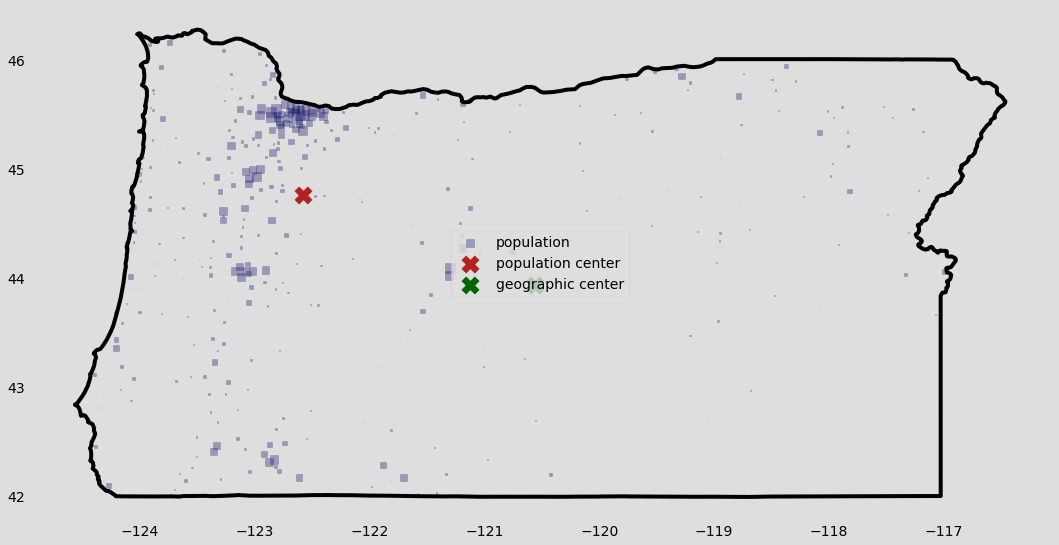

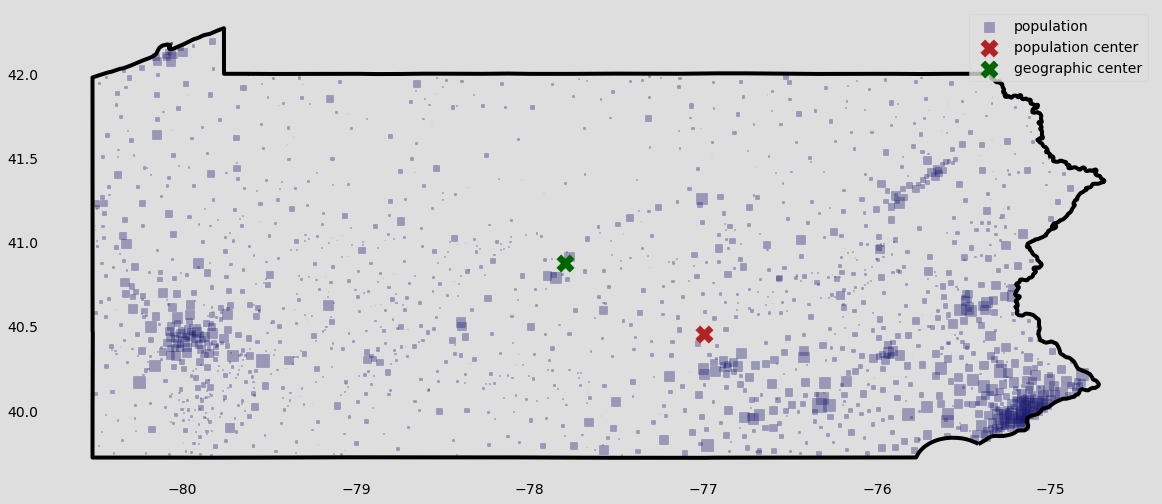

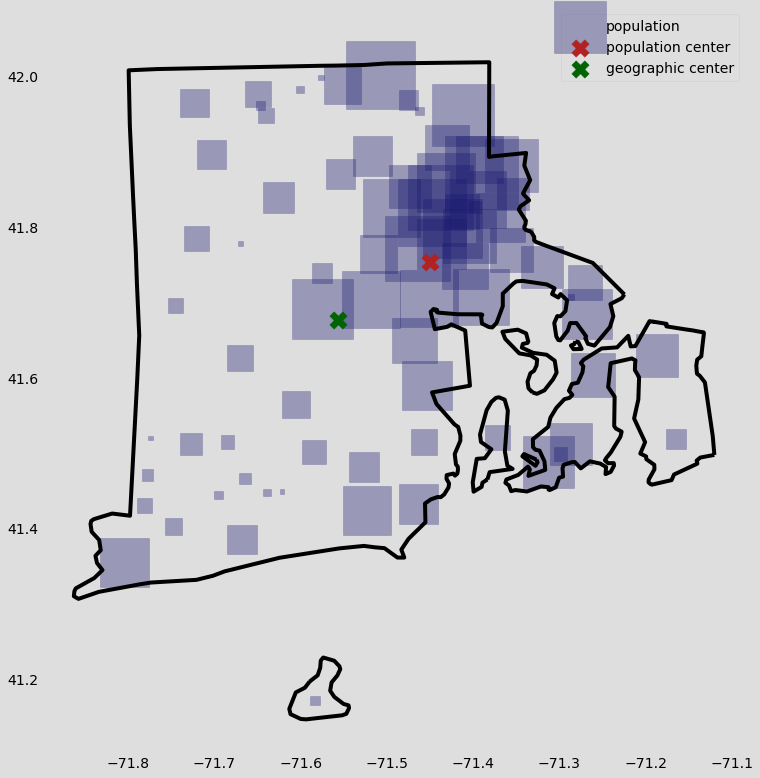

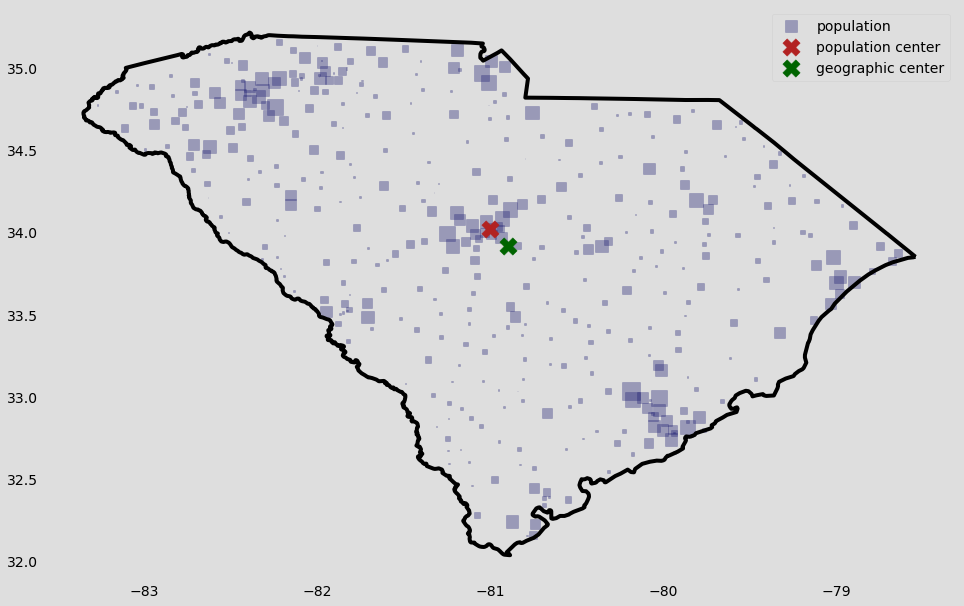

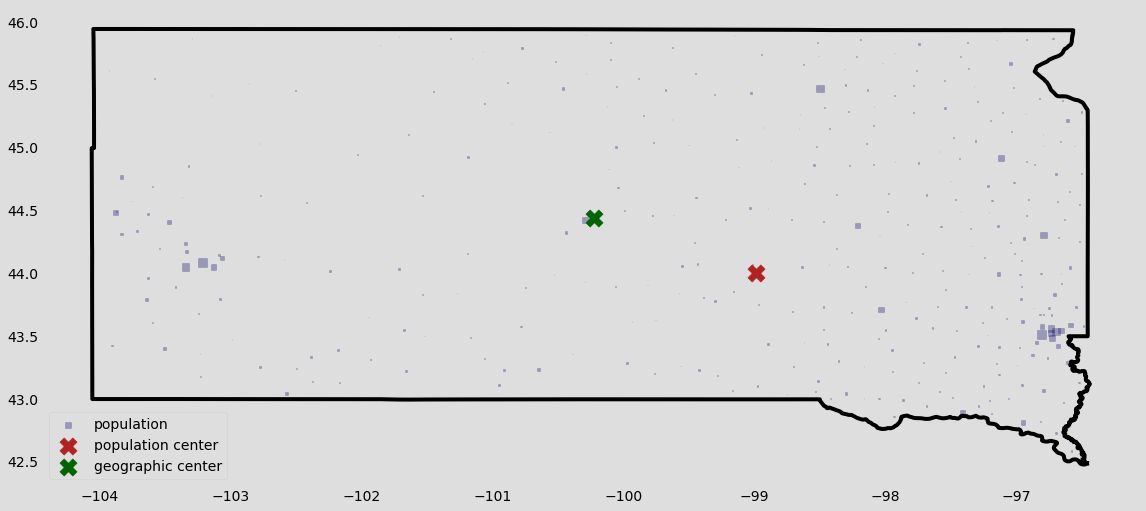

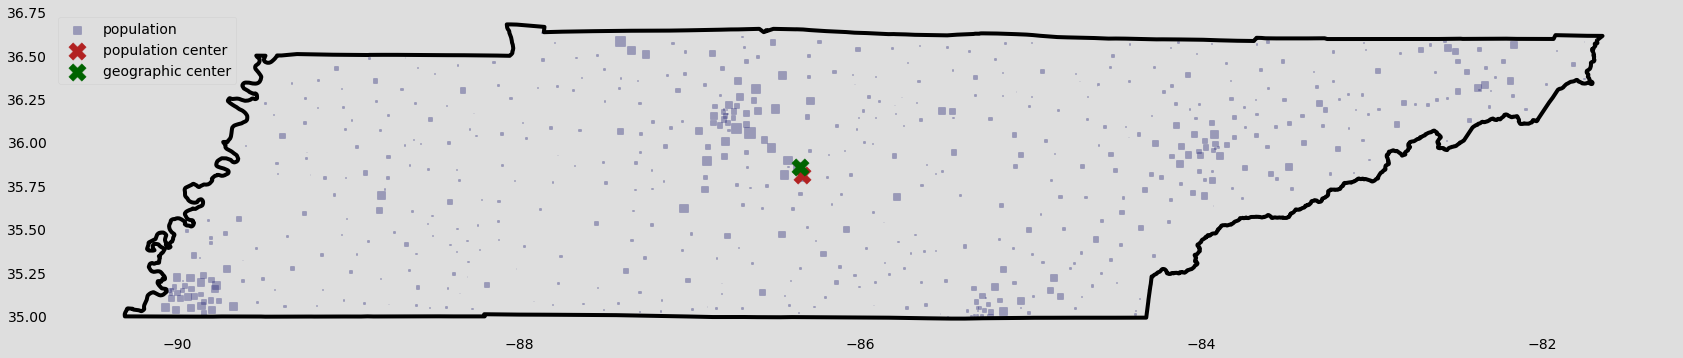

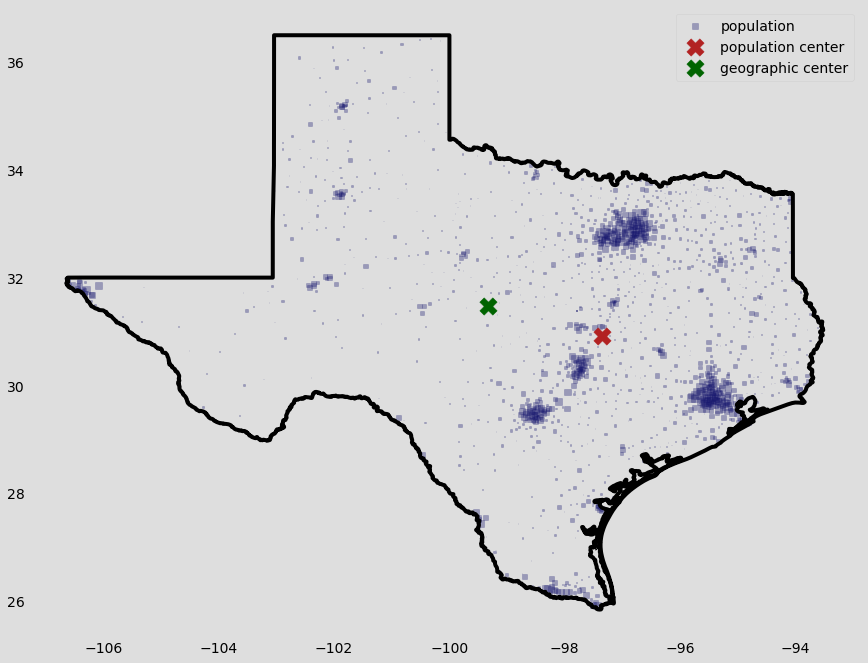

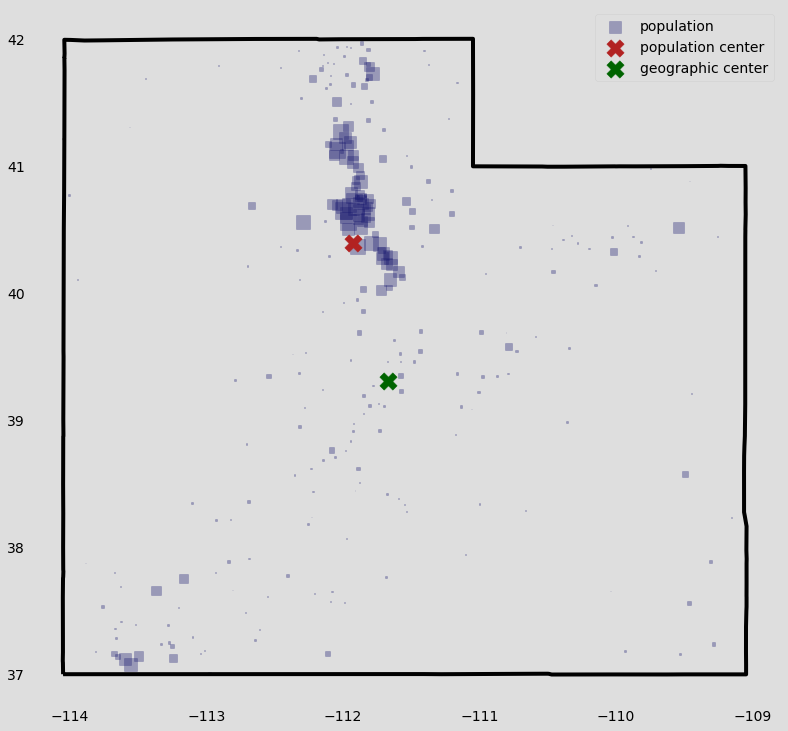

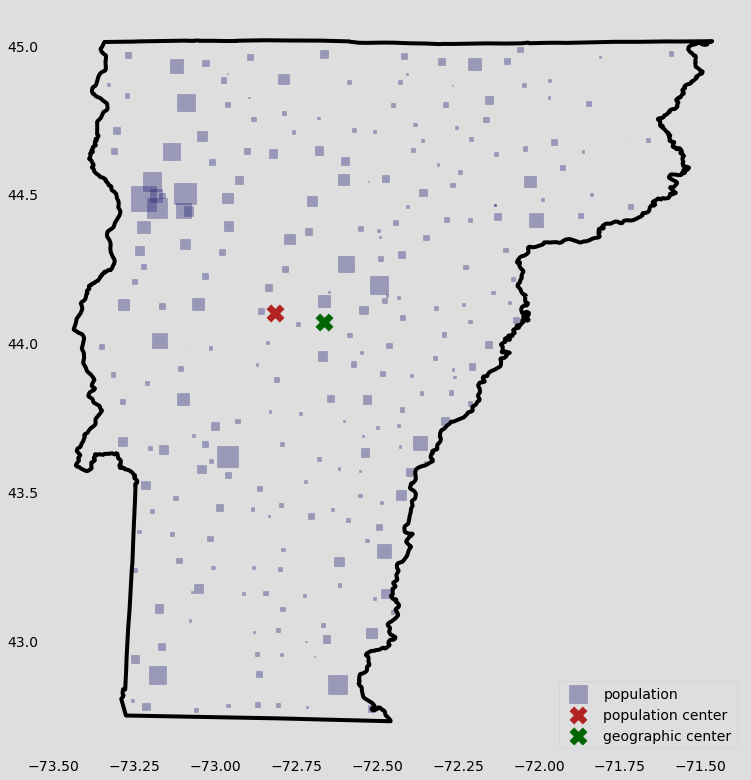

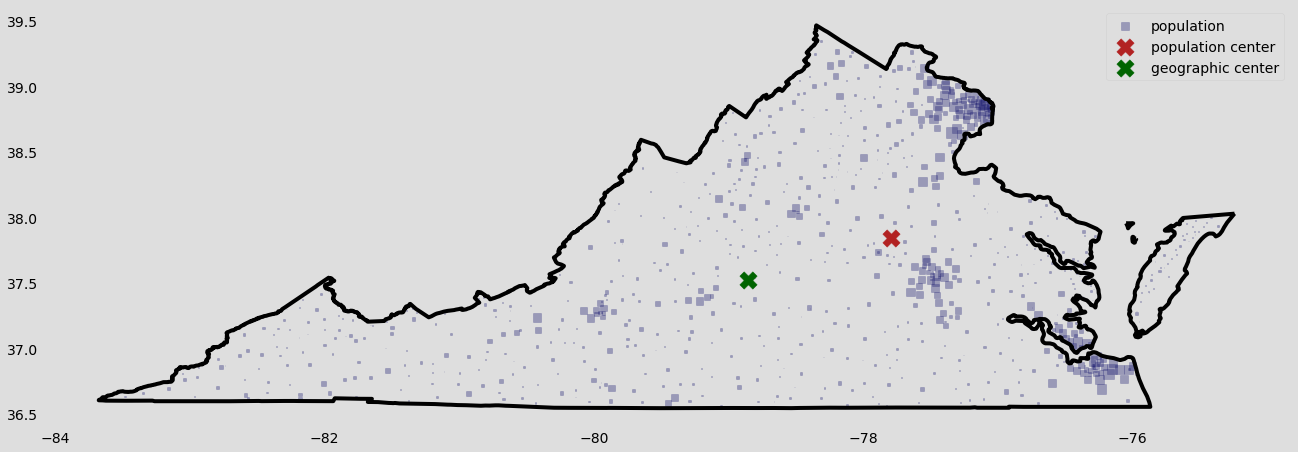

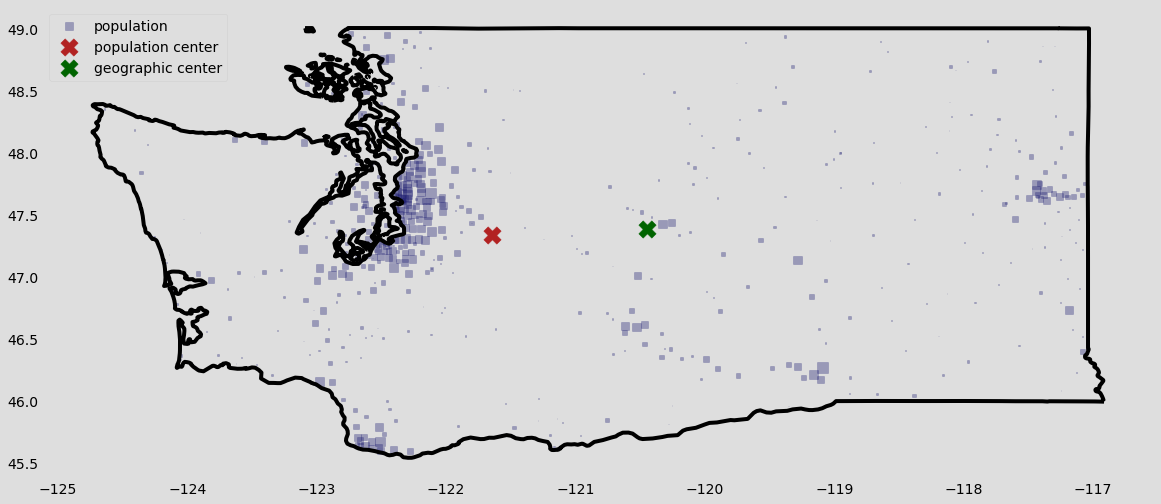

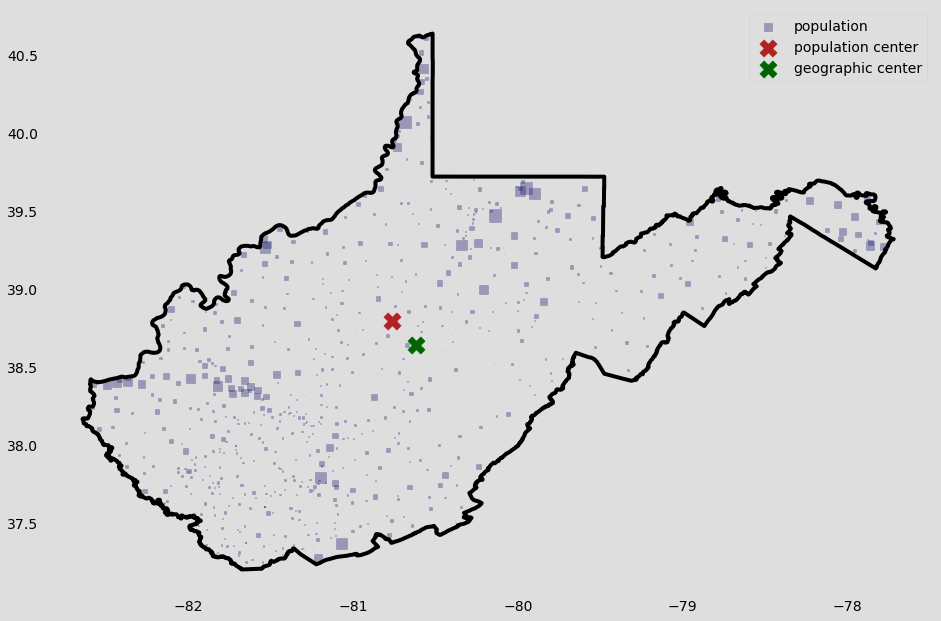

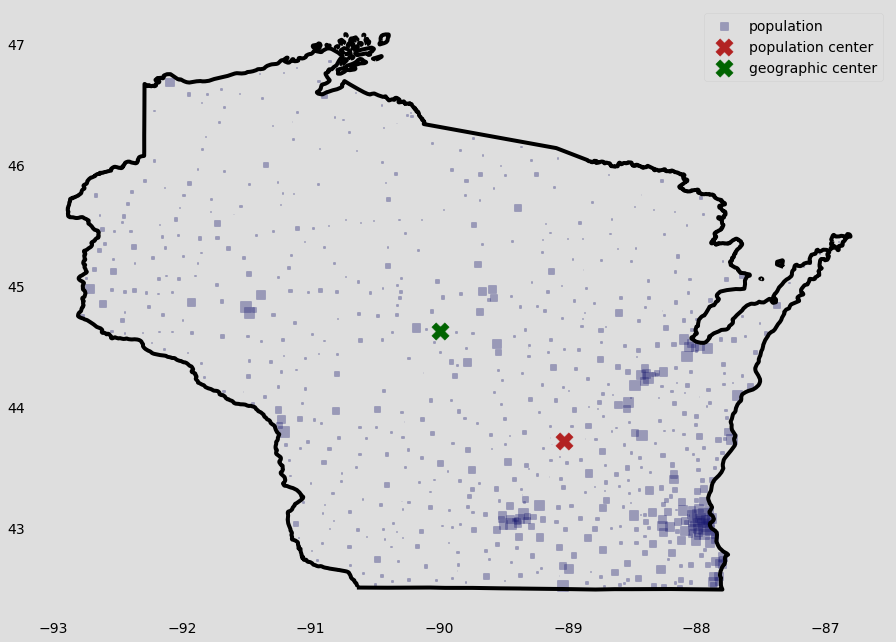

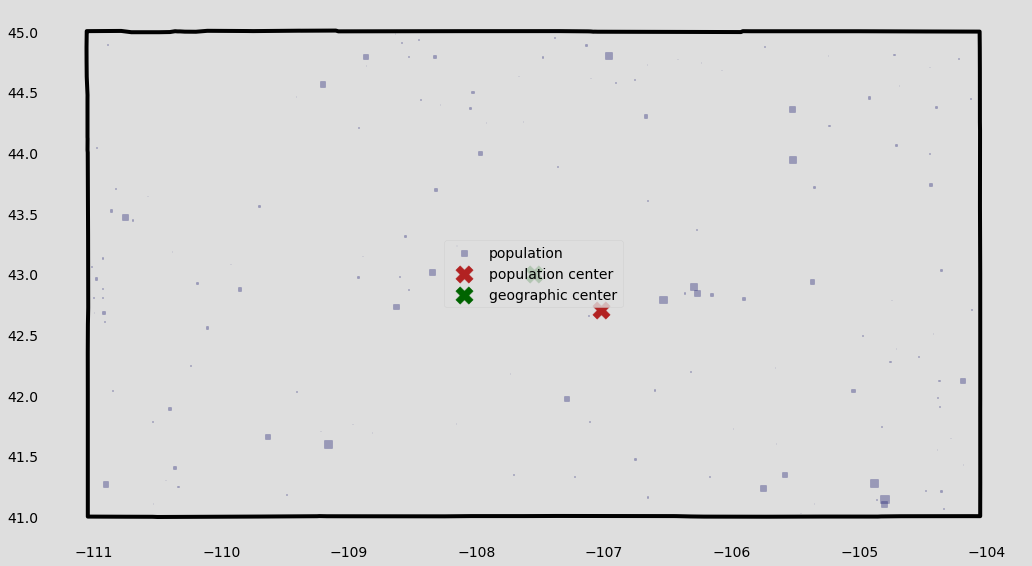

In [15]:
state_names = get_state_names()
geo_data = get_geo_data()
state_boundaries = get_state_boundaries()
s = 12
color = "#dedede"
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = color
plt.rcParams['figure.facecolor'] = color
plt.rcParams['axes.edgecolor'] = color
for state, abbrev in state_names:
    geo_center = geo_data[state]
    soup = get_wpr_soup(state.replace(' ', '-'))
    pop_by_zip = get_pop_by_zip(soup)
    zip_by_latlong = get_zip_by_latlong(abbrev)
    joined_data = pop_by_zip.join(zip_by_latlong)
    joined_data = drop_null_values(joined_data)
    lat_avg, long_avg = find_com(joined_data)
    ht, wd = get_ht_wd(get_extent(state_boundaries, state, border=0.1))
    plot(joined_data, figsize=((s*(ht/wd)**0.5, s*(wd/ht)**0.5)), ratio=10*ht**2, attrs={"color": 'midnightblue', 'marker': ','})
    plot_state(state_boundaries, state)
    plt.scatter(long_avg, lat_avg, marker='X', s=300, c='firebrick', label='population center')
    plt.scatter(geo_center[1], geo_center[0], marker='X', s=300, c='darkgreen', label='geographic center')
    plt.legend()
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(False)
#     plt.title(state.title())
    plt.savefig('states/' + state.replace(' ', '-') + '.png', facecolor=color)

*Thanks for reading!*